In [917]:
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots

In [1148]:
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols))

df = df_raw.copy()

In [1388]:
df.head()

,Zone,State,City,Name,Type,Establishment Year,time needed to visit in hrs,Google review rating,Entrance Fee in INR,Airport with 50km Radius,Weekly Off,Significance,DSLR Allowed,Number of google review in lakhs,Best Time to visit
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,NaN,Historical,Yes,2.60,Evening
1,Northern,Delhi,Delhi,Humayun's Tomb,Tomb,1572,2.0,4.5,30,Yes,NaN,Historical,Yes,0.40,Afternoon
2,Northern,Delhi,Delhi,Akshardham Temple,Temple,2005,5.0,4.6,60,Yes,NaN,Religious,No,0.40,Afternoon
3,Northern,Delhi,Delhi,Waste to Wonder Park,Theme Park,2019,2.0,4.1,50,Yes,Monday,Environmental,Yes,0.27,Evening
4,Northern,Delhi,Delhi,Jantar Mantar,Observatory,1724,2.0,4.2,15,Yes,NaN,Scientific,Yes,0.31,Morning


In [56]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 16)
The dataset comprises 325 properties described across 16 attributes.


In [66]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       2
Name: count, dtype: int64


In [62]:
data_types = df.dtypes
 
# View a few datatypes from the dataset (first and last 5 features)
print(data_types)

Unnamed: 0                            int64
Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


In [1150]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

            Missing Values  Percentage
Weekly Off             293   90.153846


In [90]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        325 non-null    int64  
 1   Zone                              325 non-null    object 
 2   State                             325 non-null    object 
 3   City                              325 non-null    object 
 4   Name                              325 non-null    object 
 5   Type                              325 non-null    object 
 6   Establishment Year                325 non-null    object 
 7   time needed to visit in hrs       325 non-null    float64
 8   Google review rating              325 non-null    float64
 9   Entrance Fee in INR               325 non-null    int64  
 10  Airport with 50km Radius          325 non-null    object 
 11  Weekly Off                        32 non-nul

In [1192]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary columns to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(
    lambda x: int(re.findall('[0-9-]+', x)[0]) if re.findall('[0-9-]+', x) != [] else np.nan).apply(
    lambda x: x * 100 if abs(x) < 100 else x)

# Clean visit column category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

In [1162]:
#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale heavily skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [1164]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1583.042254    43.621720 -9.073084e-16    1.834637   
std       0.459634   689.989850   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

Proceeding with univariate analysis

In [943]:
def univariate(x, df=df):
    display(df.sort_values(x, ascending = False).head())

    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())
    
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)))
    fig.show()

,zone,state,city,name,type,year,time,rating,fee,airport,...,camera,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log
78,Western,Gujarat,Ahmedabad,Science City,Science,2002,7.0,4.4,500,Yes,...,Yes,0.11,Anytime,1,1,2002.0,71.428571,-0.314250,1,6.214608
200,Northern,Jammu and Kashmir,Anantnag,Amarnath Cave,Temple,Unknown,6.0,4.5,0,No,...,Yes,0.11,Anytime,1,0,NaN,0.000000,0.050504,0,-inf
110,Southern,Kerala,Kochi,Wonderla Amusement Park,Amusement Park,2016,5.5,4.6,750,Yes,...,Yes,0.41,Anytime,1,1,2016.0,136.363636,0.415259,1,6.620073
15,Northern,Delhi,Delhi,National Science Centre,Science,1992,5.0,4.4,70,Yes,...,Yes,0.23,Anytime,1,1,1992.0,14.000000,-0.314250,1,4.248495
26,Western,Maharastra,Lonavala,Imagicaa,Amusement Park,2013,5.0,1.4,1149,No,...,Yes,0.95,Anytime,1,0,2013.0,229.800000,-11.256880,1,7.046647


,zone,state,city,name,type,year,time,rating,fee,airport,...,camera,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,...,Yes,2.600,Evening,1,1,1921.0,0.0,0.415259,1,-inf
220,Eastern,West Bengal,Bolpur,Kankalitala Temple,Temple,Unknown,0.5,4.7,0,Yes,...,No,0.045,Anytime,0,1,NaN,0.0,0.780013,0,-inf
221,Eastern,West Bengal,Hooghly,Hangseswari Temple,Temple,1814,0.5,4.6,0,Yes,...,No,0.070,Anytime,0,1,1814.0,0.0,0.415259,1,-inf
43,Eastern,West Bengal,Kolkata,Howrah Bridge,Bridge,1943,0.5,4.6,0,Yes,...,No,1.200,Anytime,0,1,1943.0,0.0,0.415259,1,-inf
208,Northern,Ladakh,Leh,Magnetic Hill,Gravity Hill,Unknown,0.5,3.7,0,Yes,...,Yes,0.100,Anytime,1,1,NaN,0.0,-2.867530,0,-inf


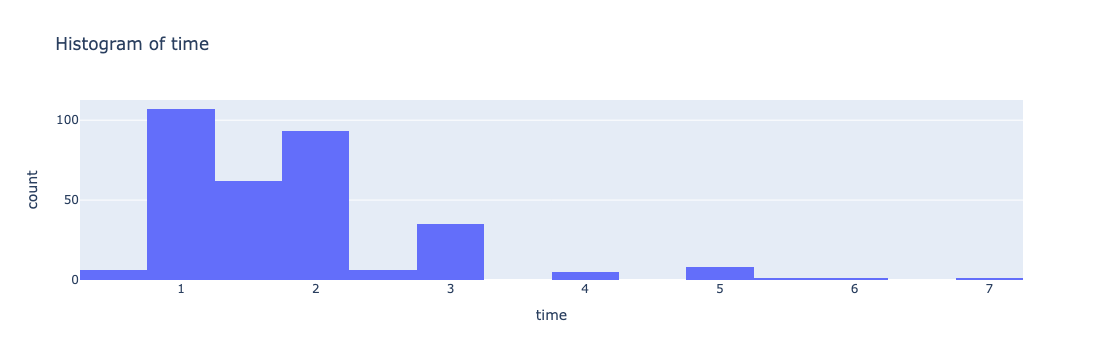

In [945]:
univariate('time')

,zone,state,city,name,type,year,time,rating,fee,airport,...,camera,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log
196,Northern,Ladakh,Leh,Pangong Tso,Lake,Unknown,2.0,4.9,20,Yes,...,Yes,0.150,Morning,1,1,NaN,10.0,1.509522,0,2.995732
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,Yes,0.100,Evening,1,1,NaN,2500.0,1.509522,0,8.922658
92,Northern,Punjab,Amritsar,Golden Temple (Harmandir Sahib),Religious Site,1604,1.5,4.9,0,Yes,...,Yes,1.900,Anytime,1,1,1604.0,0.0,1.509522,1,-inf
94,Northern,Punjab,Amritsar,Wagah Border,Border Crossing,1950,2.0,4.8,0,Yes,...,Yes,0.170,Evening,1,1,1950.0,0.0,1.144767,1,-inf
207,Northern,Ladakh,Dras,Dras War Memorial,War Memorial,Unknown,1.0,4.8,0,No,...,Yes,0.012,Anytime,1,0,NaN,0.0,1.144767,0,-inf


,zone,state,city,name,type,year,time,rating,fee,airport,...,camera,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log
26,Western,Maharastra,Lonavala,Imagicaa,Amusement Park,2013,5.0,1.4,1149,No,...,Yes,0.95,Anytime,1,0,2013.0,229.8,-11.256880,1,7.046647
208,Northern,Ladakh,Leh,Magnetic Hill,Gravity Hill,Unknown,0.5,3.7,0,Yes,...,Yes,0.10,Anytime,1,1,NaN,0.0,-2.867530,0,-inf
103,Southern,Kerala,Kumarakom,Kumarakom Bird Sanctuary,Bird Sanctuary,1972,2.0,3.8,50,Yes,...,Yes,0.10,Anytime,1,1,1972.0,25.0,-2.502776,1,3.912023
264,Southern,Andhra Pradesh,Visakhapatnam,Matsyadarshini Aquarium,Aquarium,Unknown,1.0,3.8,20,Yes,...,Yes,0.03,Anytime,1,1,NaN,20.0,-2.502776,0,2.995732
167,Northern,Himachal Pradesh,Kufri,Kufri Fun World,Ski Resort,1975,5.0,3.8,1500,Yes,...,Yes,0.10,Anytime,1,1,1975.0,300.0,-2.502776,1,7.313220


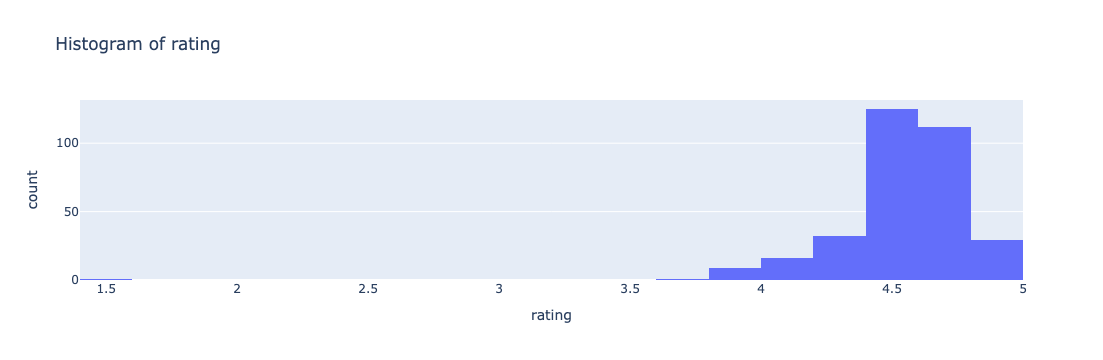

In [947]:
univariate('rating')

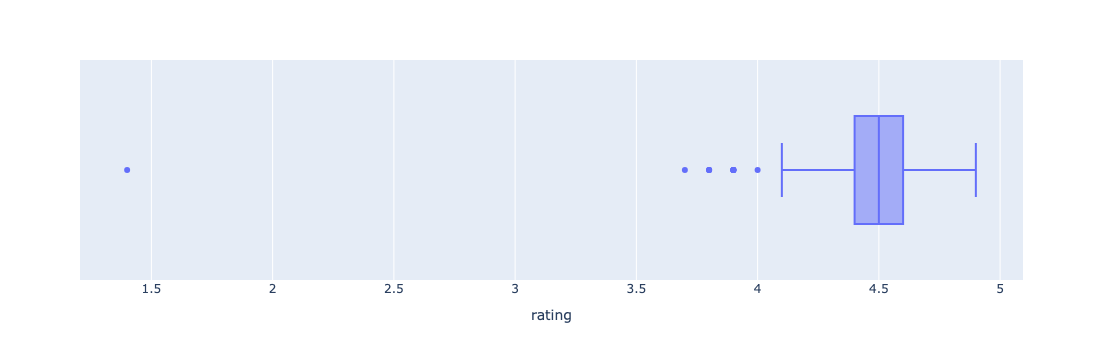

In [137]:
x = 'rating'

fig = px.box(df, x=x)

fig.show()

,zone,state,city,name,type,year,time,rating,fee,airport,...,camera,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,Yes,0.10,Evening,1,1,NaN,2500.000000,1.509522,0,8.922658
68,Western,Gujarat,Junagadh,Gir National Park,National Park,1965,3.0,4.5,3500,No,...,Yes,0.08,Morning,1,0,1965.0,1166.666667,0.050504,1,8.160518
161,Northern,Himachal Pradesh,Bir Billing,Paragliding Site,Adventure Sport,2005,2.0,4.8,2500,No,...,Yes,0.01,Anytime,1,0,2005.0,1250.000000,1.144767,1,7.824046
47,Eastern,West Bengal,Kolkata,Eden Gardens,Cricket Ground,1864,3.0,4.1,2500,Yes,...,Yes,0.10,Anytime,1,1,1864.0,833.333333,-1.408513,1,7.824046
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,Yes,7.40,Anytime,1,1,2011.0,750.000000,0.415259,1,7.313220


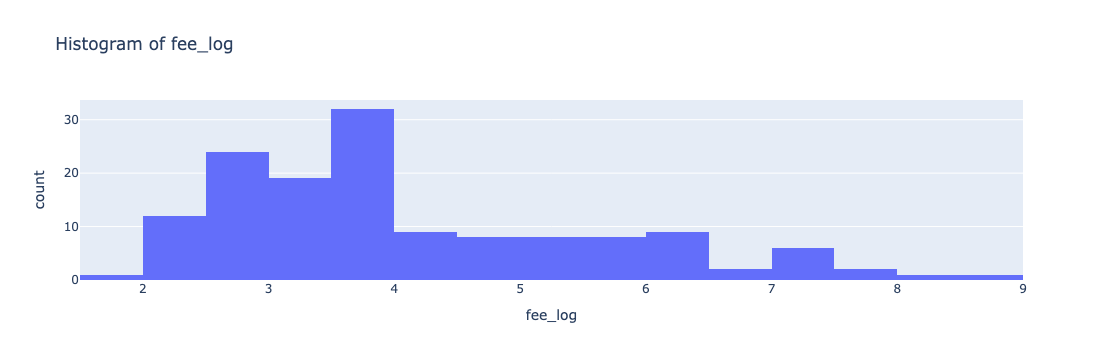

In [949]:
univariate('fee_log')

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log,reviews_log
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,7.40,Anytime,1,1,2011.0,750.0,0.415259,1,7.313220,2.001480
17,Western,Maharastra,Mumbai,Gateway of India,Monument,1924,1.0,4.6,0,Yes,...,3.60,Anytime,1,1,1924.0,0.0,0.415259,1,0.000000,1.280934
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,...,2.60,Evening,1,1,1921.0,0.0,0.415259,1,0.000000,0.955511
111,Southern,Karnataka,Mysore,Mysore Palace,Palace,1912,2.0,4.6,50,Yes,...,2.50,Anytime,1,1,1912.0,25.0,0.415259,1,3.912023,0.916291
181,Central,Uttar Pradesh,Agra,Taj Mahal,Mausoleum,1632,2.0,4.6,50,Yes,...,2.25,Morning,1,1,1632.0,25.0,0.415259,1,3.912023,0.810930


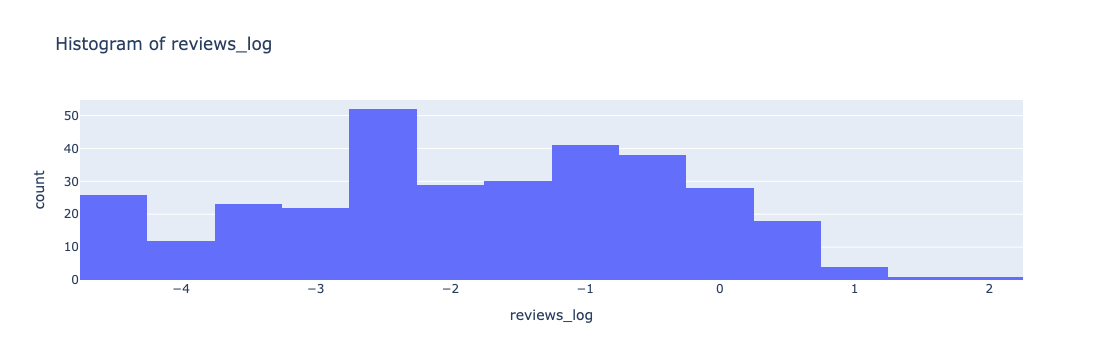

In [985]:
univariate('reviews_log')

,zone,state,city,name,type,year,time,rating,fee,airport,...,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,year_bin,fee_log,reviews_log,cost_ratio_log
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,Evening,1,1,NaN,2500.000000,1.509522,0,8.922658,-2.302585,7.824046
161,Northern,Himachal Pradesh,Bir Billing,Paragliding Site,Adventure Sport,2005,2.0,4.8,2500,No,...,Anytime,1,0,2005.0,1250.000000,1.144767,1,7.824046,-4.605170,7.130899
68,Western,Gujarat,Junagadh,Gir National Park,National Park,1965,3.0,4.5,3500,No,...,Morning,1,0,1965.0,1166.666667,0.050504,1,8.160518,-2.525729,7.061906
47,Eastern,West Bengal,Kolkata,Eden Gardens,Cricket Ground,1864,3.0,4.1,2500,Yes,...,Anytime,1,1,1864.0,833.333333,-1.408513,1,7.824046,-2.302585,6.725434
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,Anytime,1,1,2011.0,750.000000,0.415259,1,7.313220,2.001480,6.620073


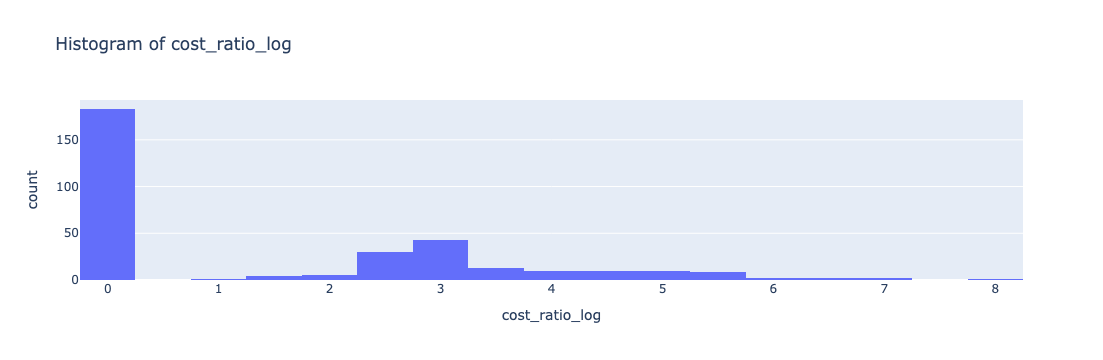

In [995]:
univariate('cost_ratio_log')

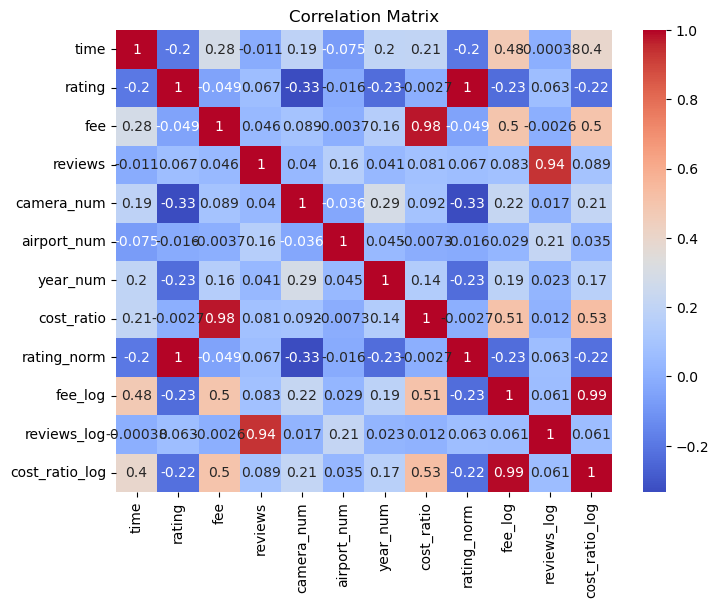

In [1166]:
# Correlation matrix between numerical variables on clean data
plt.figure(figsize=(8,6))
corr_matrix = df.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

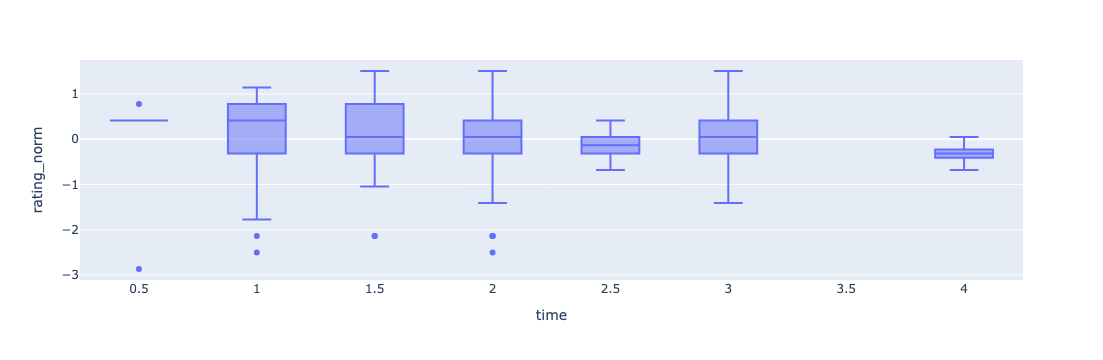

,name,time,rating_norm
26,Imagicaa,5.0,-11.256880
167,Kufri Fun World,5.0,-2.502776
24,Essel World,5.0,-0.679004
15,National Science Centre,5.0,-0.314250
78,Science City,7.0,-0.314250
200,Amarnath Cave,6.0,0.050504
110,Wonderla Amusement Park,5.5,0.415259
2,Akshardham Temple,5.0,0.415259
198,Vaishno Devi,5.0,0.780013
180,Valley of Flowers,5.0,0.780013


In [999]:
x = 'time'
y = 'rating_norm'
text = 'name'

#filter outliers
temp_df = df[[x, y]]
temp_df = temp_df.loc[temp_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

fig = px.box(temp_df, x=x, y=y)
fig.show()

outliers = df[[x, y]].dropna()
outliers = outliers.loc[~outliers.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
outliers.merge(df, how = 'left', left_index = True, right_index = True, suffixes = ['', '_y'])[[text, x, y]].sort_values(by = y)

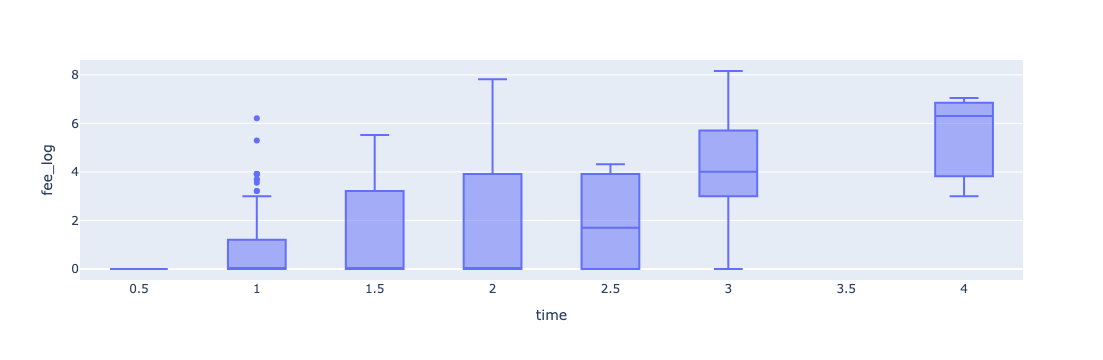

,name,time,fee_log
162,Triund Trek,5.0,0.000000
200,Amarnath Cave,6.0,0.000000
198,Vaishno Devi,5.0,0.000000
2,Akshardham Temple,5.0,4.094345
15,National Science Centre,5.0,4.248495
180,Valley of Flowers,5.0,5.010635
78,Science City,7.0,6.214608
110,Wonderla Amusement Park,5.5,6.620073
24,Essel World,5.0,7.046647
26,Imagicaa,5.0,7.046647


In [1145]:
x = 'time'
y = 'fee_log'
text = 'name'

#filter outliers
temp_df = df[[x, y]]
temp_df = temp_df.loc[temp_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

fig = px.box(temp_df, x=x, y=y)
fig.show()

outliers = df[[x, y]].dropna()
outliers = outliers.loc[~outliers.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
outliers.merge(df, how = 'left', left_index = True, right_index = True, suffixes = ['', '_y'])[[text, x, y]].sort_values(by = y)

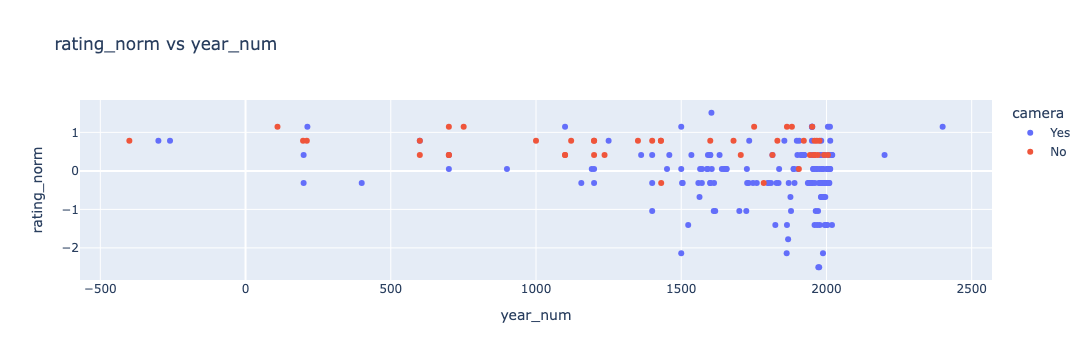

,name,year_num,rating_norm
26,Imagicaa,2013.0,-11.256880
229,Barabati Fort,-987.0,0.050504
189,Dhamek Stupa,-500.0,0.415259
136,Khajuraho Group of Monuments,-850.0,0.780013
174,Badrinath Temple,-820.0,1.144767
140,Mahakaleshwar Jyotirlinga,-3500.0,1.144767


In [143]:
x = 'year_num'
y = 'rating_norm'
text = 'name'
cat = 'camera'

#filter outliers
temp_df = df[[x, y, cat, text]]
temp_df = temp_df.loc[temp_df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
 
fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text,title = y + " vs " + x)
fig.show()

outliers = df[[x, y]].dropna()
outliers = outliers.loc[~outliers.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
outliers.merge(df, how = 'left', left_index = True, right_index = True, suffixes = ['', '_y'])[[text, x, y]].sort_values(by = y)

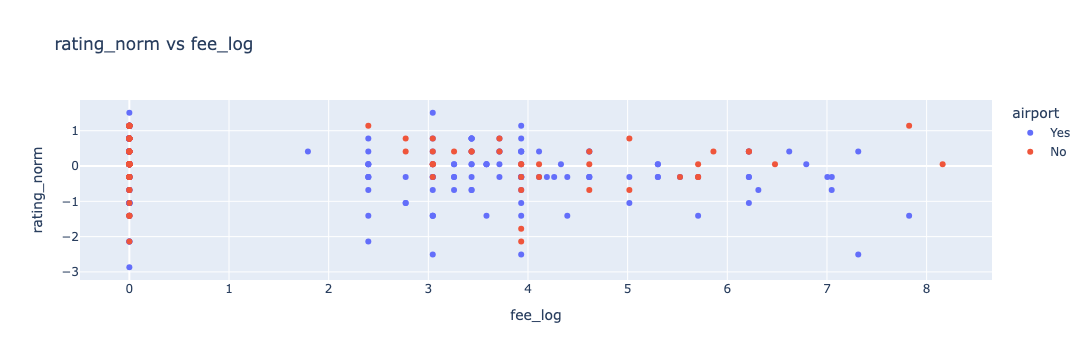

,name,fee_log,rating_norm
26,Imagicaa,7.047517,-11.256880
72,Rann Utsav,8.922792,1.509522


In [1170]:
x = 'fee_log'
y = 'rating_norm'
text = 'name'
cat = 'airport'

#filter outliers
temp_df = df[[x, y, cat, text]]
temp_df = temp_df.loc[temp_df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
 
fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text,title = y + " vs " + x)
fig.show()

outliers = df[[x, y]].dropna()
outliers = outliers.loc[~outliers.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
outliers.merge(df, how = 'left', left_index = True, right_index = True, suffixes = ['', '_y'])[[text, x, y]].sort_values(by = y)

In [ ]:
#categorical analysis

In [1095]:
def categorical(x, y, df=df):
    cat_lst = []
    p_lst = []
    
    fig = px.histogram(df.groupby(x, observed = False).filter(lambda x: len(x) > 3), x=x).update_xaxes(categoryorder="total descending")

    fig.show()
    
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    fig = px.bar(temp_df, y=y)

    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    fig.show()

    print(pg.anova(data=df, dv=y, between=x))
    
    for category in temp_df.index:
        p = sp.stats.ttest_1samp(df[df[x] == category][y], df[y].mean())[1]
        if p < 0.05:
            cat_lst.append(category)
            p_lst.append(p)

    p_df = pd.DataFrame(list(zip(cat_lst, p_lst)), columns = ['category', 'p-value'])
    if not p_df.empty:
        display(p_df)

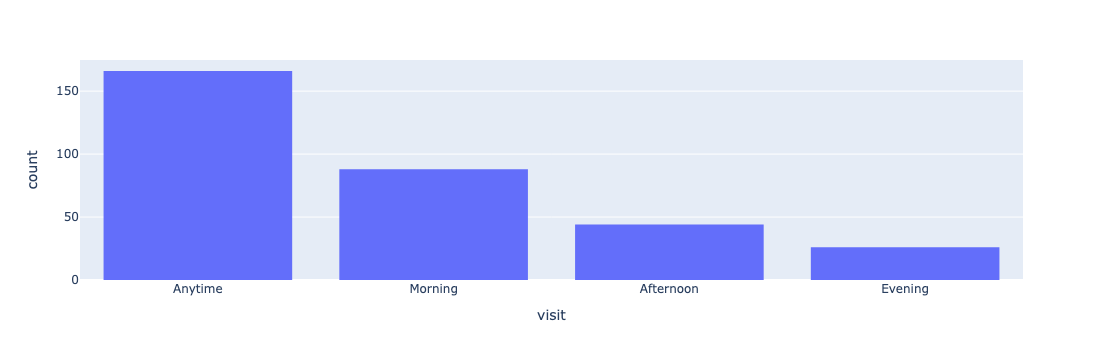

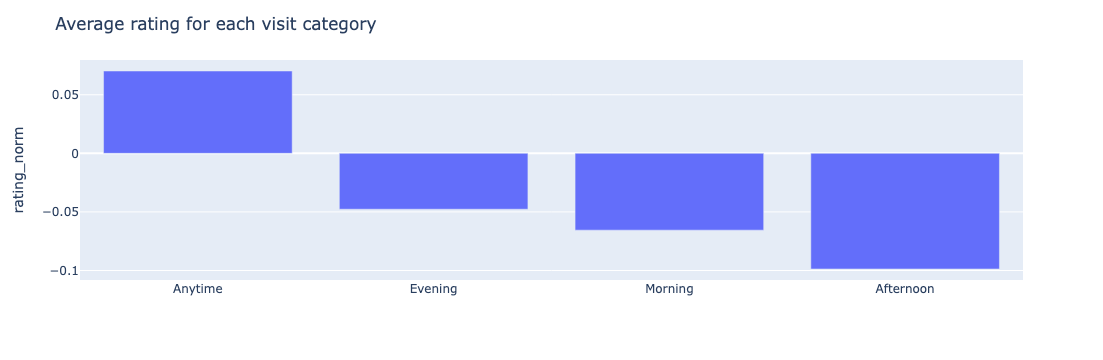

  Source  ddof1  ddof2         F   p-unc       np2
0  visit      4    320  0.441748  0.7784  0.005492


In [1097]:
categorical('visit', 'rating_norm')

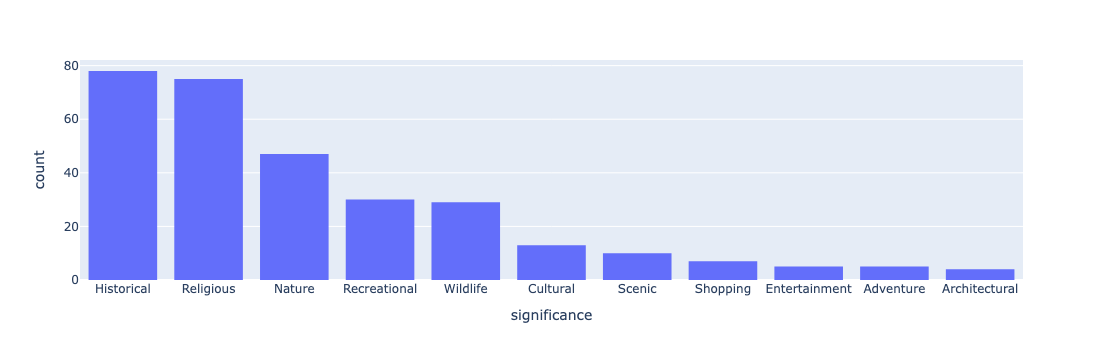

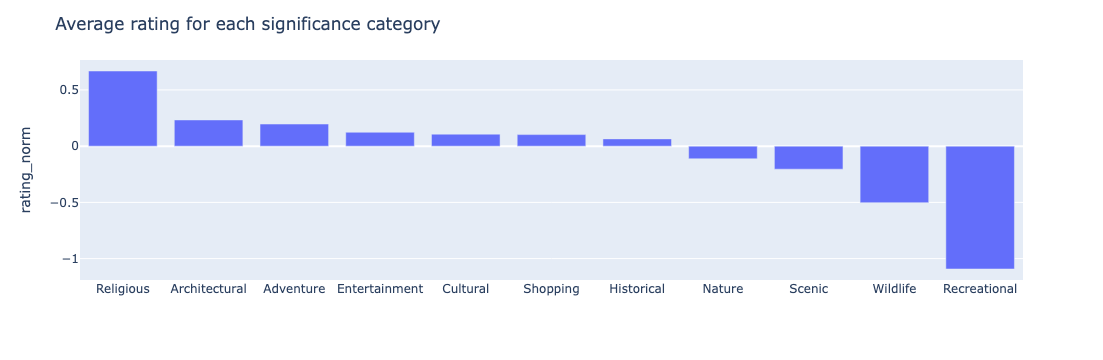

         Source  ddof1  ddof2         F         p-unc       np2
0  significance     24    300  4.714182  3.796962e-11  0.273855


,category,p-value
0,Religious,5.739242e-24
1,Wildlife,3.100008e-04
2,Recreational,9.313066e-03


In [1099]:
categorical('significance', 'rating_norm')

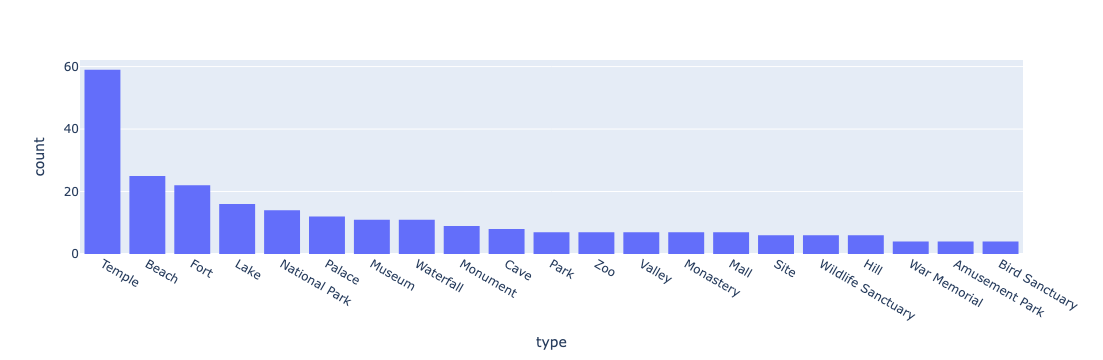

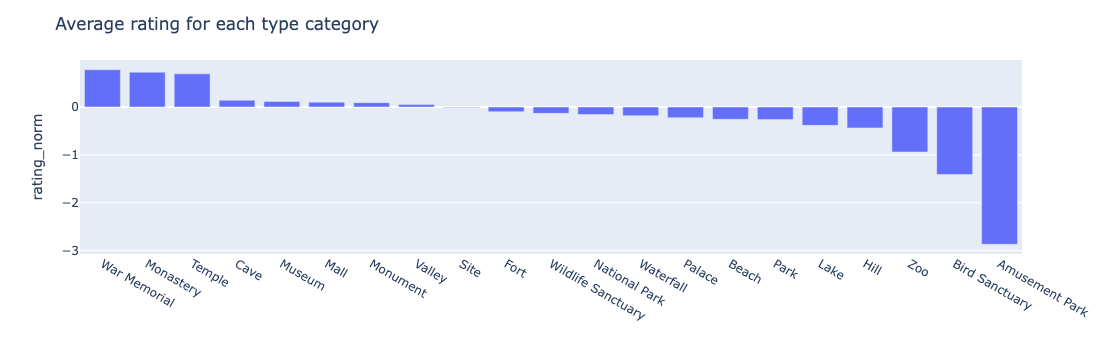

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  2.557954  2.177626e-08  0.443647


,category,p-value
0,War Memorial,3.418494e-02
1,Monastery,2.603358e-04
2,Temple,1.221772e-20
3,Zoo,8.655803e-04


In [1101]:
categorical('type', 'rating_norm')

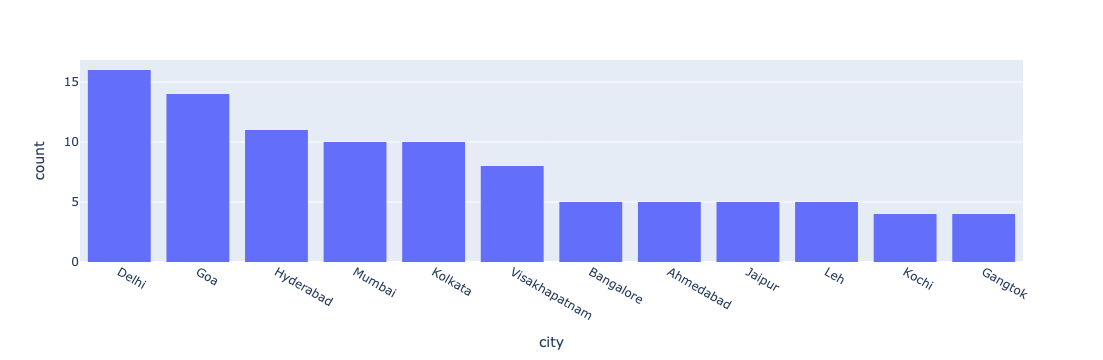

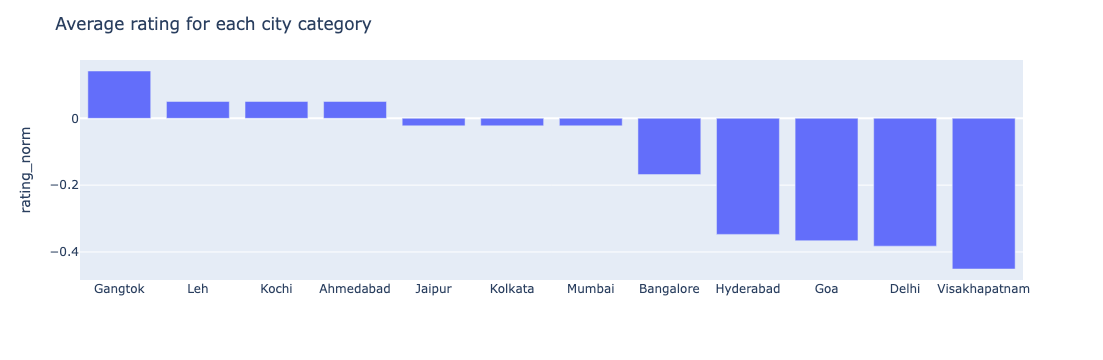

  Source  ddof1  ddof2         F     p-unc       np2
0   city    213    111  0.878711  0.788786  0.627723


,category,p-value
0,Delhi,0.047074


In [1103]:
categorical('city', 'rating_norm')

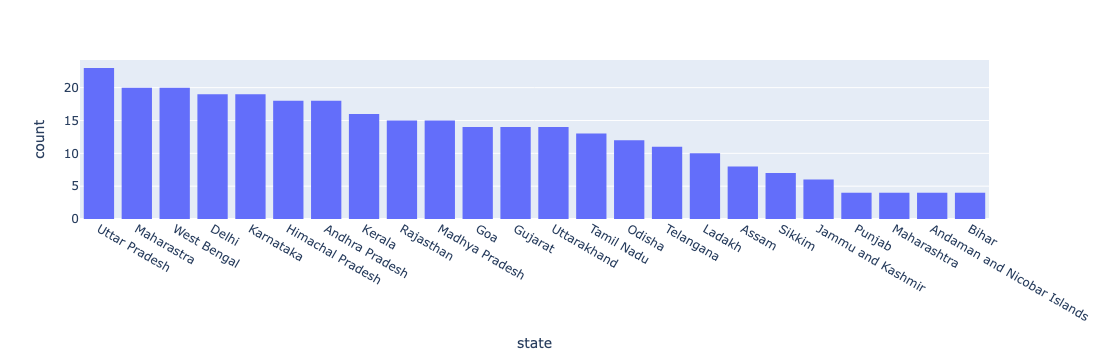

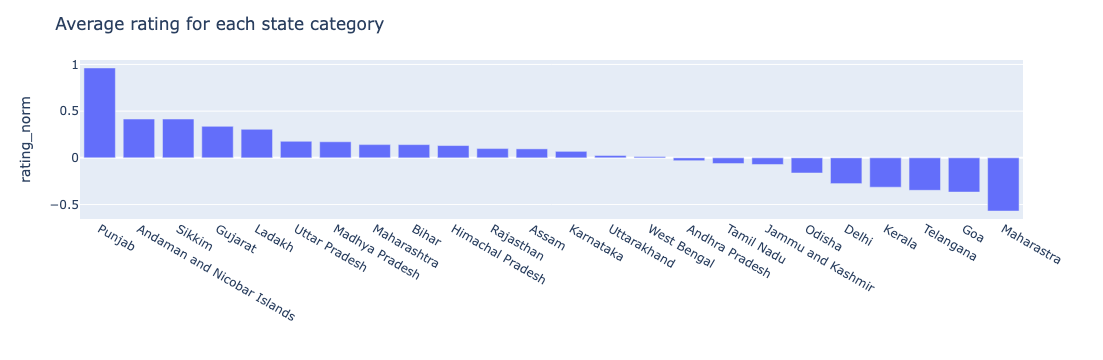

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


,category,p-value
0,Gujarat,0.035801


In [1105]:
categorical('state', 'rating_norm')

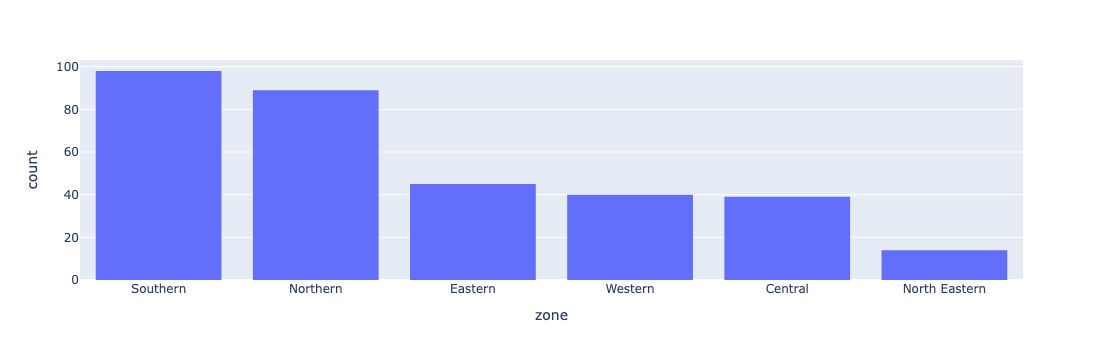

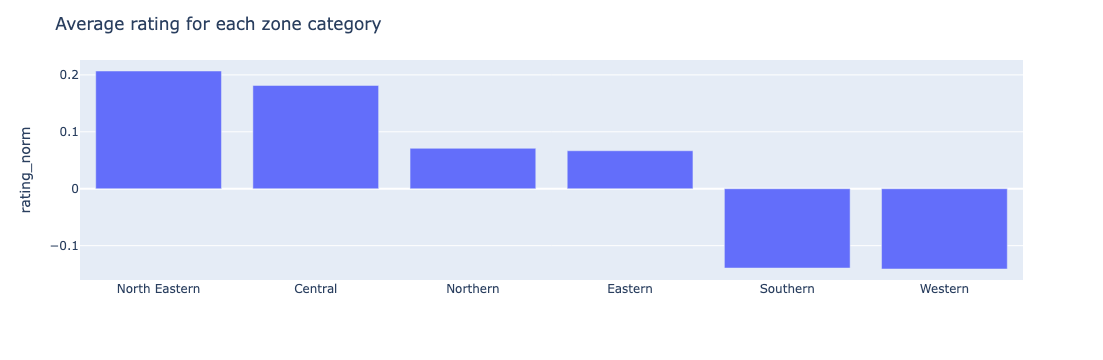

  Source  ddof1  ddof2         F    p-unc       np2
0   zone      5    319  1.043268  0.39215  0.016089


In [1107]:
categorical('zone', 'rating_norm')

In [1290]:
def find_min_value(function, start, end, step, var_1, var_2):
    """
    Finds the minimum value of a function within a given range.

    Args:
        function: The function to minimize.
        start: The starting point of the range.
        end: The ending point of the range.
        step: The step size for iteration.

    Returns:
        The minimum value of the function within the range.
    """

    x_values = [x for x in range(start, end + 1, step)]
    y_values = [function(x, var_1, var_2) for x in x_values]

    min_value = min(y_values)
    min_index = y_values.index(min_value)
    min_x = x_values[min_index]

    return min_value, min_x




Minimum value: 0.007118608807640988
x value at minimum: 1970


In [1292]:
def chisqp(year, var_1, var_2): 
    return chi2_contingency(pd.crosstab(df[var_1].apply(lambda x: 1 if x > year else 0), df[var_2]))[1]

min_value, min_x = find_min_value(chisqp, int(df['year_num'].min()), 1975, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.007118608807640988
x value at minimum: 1970


In [1294]:
def chisqp(year, var_1, var_2): 
    return chi2_contingency(pd.crosstab(df[var_1].apply(lambda x: 1 if x > year else 0), df[var_2]))[1]

min_value, min_x = find_min_value(chisqp, 1300, 1500, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.01038452997698236
x value at minimum: 1431


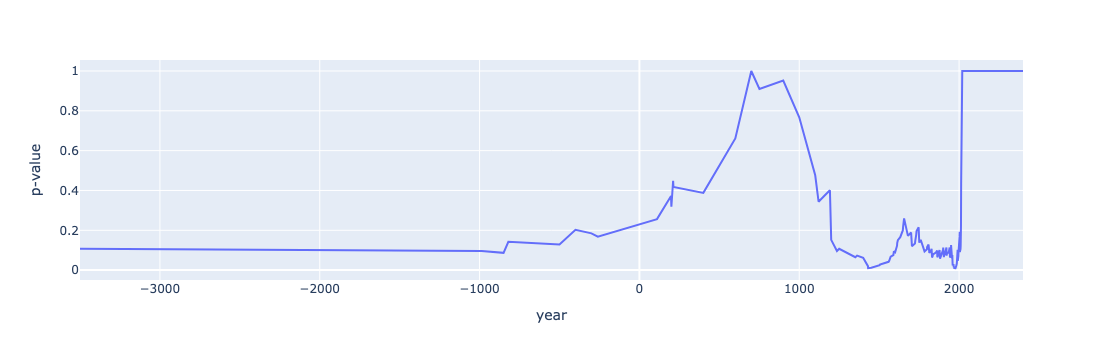

In [1246]:

p_lst= []


for year in df['year_num'].dropna():
    p_lst.append(my_function(year))
    p_df = pd.DataFrame(list(zip(df['year_num'].dropna(), p_lst)), columns = ['year', 'p-value'])
p_df


px.line(p_df.sort_values('year'), x = 'year', y = 'p-value')
    